In [1]:
%cd ..
%pwd

/home/quasar/GitHub/TradeForecast


/home/quasar/GitHub/TradeForecast/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/quasar/GitHub/TradeForecast'

In [2]:
from tradeforecast import Scrapper

ticker = 'AAPL'
scrapper = Scrapper(ticker)

exported_fname = scrapper.export_historic_data()

[*********************100%***********************]  1 of 1 completed


In [3]:
from tradeforecast.augmentation import DataEntryPoint, Indicators, FeatureEngg, RNNDataset, train_test_split
import polars as pl

data_entry = DataEntryPoint(exported_fname[ticker])

indicators = Indicators(data_entry)
indicators.add_moving_average().add_moving_average(ma_type='EMA').add_macd_sl().add_rsi().add_atr()

features = FeatureEngg(data_entry)
features.add_quarters().add_weeks().add_hours().add_minutes()

lf = data_entry.data.drop_nulls()
lf.collect().head()

Datetime,Close,High,Low,Open,Volume,SMA_close_9,EMA_close_9,MACD_close_12-26,MACD-SL_close_9,RSI_close_14,ATR_close_14,Quarter_sin,Quarter_cos,Week_sin,Week_cos,Hour_sin,Hour_cos,Minute_sin,Minute_cos
"datetime[μs, EST]",f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1981-01-29 19:00:00 EST,0.126116,0.127232,0.126116,0.127232,46188800,0.140563,0.137804,-0.001314,0.000148,23.832346,0.004126,1.0,0.0,0.558647,0.829406,-0.965926,0.258819,0.0,1.0
1981-02-01 19:00:00 EST,0.118862,0.11942,0.118862,0.11942,23766400,0.137959,0.134014,-0.002705,-0.000491,18.469055,0.004546,1.0,0.0,0.558647,0.829406,-0.965926,0.258819,0.0,1.0
1981-02-02 19:00:00 EST,0.123326,0.123884,0.123326,0.123326,19152000,0.135541,0.131876,-0.003426,-0.001133,29.702202,0.004609,1.0,0.0,0.652822,0.757511,-0.965926,0.258819,0.0,1.0
1981-02-03 19:00:00 EST,0.12779,0.128348,0.12779,0.12779,27865600,0.133433,0.131058,-0.003613,-0.001666,39.344816,0.004665,1.0,0.0,0.652822,0.757511,-0.965926,0.258819,0.0,1.0
1981-02-04 19:00:00 EST,0.12779,0.128906,0.12779,0.12779,7929600,0.131386,0.130404,-0.003719,-0.0021,39.344816,0.00419,1.0,0.0,0.652822,0.757511,-0.965926,0.258819,0.0,1.0


In [4]:
from torch.utils.data import DataLoader

dataset_kwargs = {'lf': lf,
                 'non_temporal': data_entry.non_temporal,
                 'temporal': data_entry.temporal,
                 'target': 'Close',
                 'look_back_len': 90,
                 'forecast_len': 5}

rnn_dataset = RNNDataset(**dataset_kwargs)

train_dataset, test_dataset = train_test_split(rnn_dataset, 0.1)
print(len(rnn_dataset), len(train_dataset), len(test_dataset))

b_size = 128
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=False, drop_last=False)
data_loader = DataLoader(rnn_dataset, batch_size=b_size, shuffle=False, drop_last=False)

10869 9783 1086


In [5]:
from tradeforecast import TFModel
from torch import nn, optim

tf_kwargs = {'input_size': len(rnn_dataset.features),
             'conv_out_size': len(rnn_dataset.features)*2,
             'kernel_size': 5,
             'hidden_size': 32,
             'n_LSTM': 2,
             'bidirectional': False,
             'fc_out_size':[],
             'output_size': rnn_dataset.forecast_len,
             'dropout': 0}

tf_model = TFModel(**tf_kwargs)
print(f"The device is set to ---> '{tf_model.device}'")

The device is set to ---> 'cuda'


In [6]:
tf_model.train_model(criterion=nn.MSELoss, optimizer=optim.SGD, n_epochs=1500, data_loader=data_loader, min_learning_rate=0.0005)

Epoch: 1/1500	LR: 1.0	Loss: 0.873995
Epoch: 2/1500	LR: 0.95	Loss: 2.535994
Epoch: 3/1500	LR: 0.9025	Loss: 1.744061
Epoch: 4/1500	LR: 0.8573749999999999	Loss: 1.556558
Epoch: 5/1500	LR: 0.8145062499999999	Loss: 1.567721
Epoch: 6/1500	LR: 0.7737809374999999	Loss: 1.627215
Epoch: 7/1500	LR: 0.7350918906249998	Loss: 1.610641
Epoch: 8/1500	LR: 0.6983372960937497	Loss: 1.453443
Epoch: 9/1500	LR: 0.6634204312890623	Loss: 1.620471
Epoch: 10/1500	LR: 0.6302494097246091	Loss: 1.656765
Epoch: 11/1500	LR: 0.5987369392383786	Loss: 1.607867
Epoch: 12/1500	LR: 0.5688000922764596	Loss: 1.724939
Epoch: 13/1500	LR: 0.5403600876626365	Loss: 1.582309
Epoch: 14/1500	LR: 0.5133420832795047	Loss: 1.491473
Epoch: 15/1500	LR: 0.48767497911552943	Loss: 1.367287
Epoch: 16/1500	LR: 0.46329123015975293	Loss: 1.552533
Epoch: 17/1500	LR: 0.44012666865176525	Loss: 1.472160
Epoch: 18/1500	LR: 0.41812033521917696	Loss: 1.448070
Epoch: 19/1500	LR: 0.3972143184582181	Loss: 1.387574
Epoch: 20/1500	LR: 0.37735360253530714	

In [7]:
model_fname = tf_model.save_model_state(ticker_interval='AAPL_1d_engg')
model_fname

'AAPL_1d_engg_TF(21553_19_5)-cuda.pth'

In [8]:
from sklearn.metrics import mean_absolute_percentage_error
from torch import Tensor

y: Tensor; y_preds: Tensor
y, y_preds = tf_model.test_model(test_loader)

y_arr, y_preds_arr = y.cpu().numpy(), y_preds.cpu().numpy()
print(y_arr.shape, y_preds_arr.shape)

y_arr = rnn_dataset.inverse_transform(y_arr)
y_preds_arr = rnn_dataset.inverse_transform(y_preds_arr)
mean_absolute_percentage_error(y_arr, y_preds_arr)

(1086, 5) (1086, 5)


np.float64(0.2331308832993059)

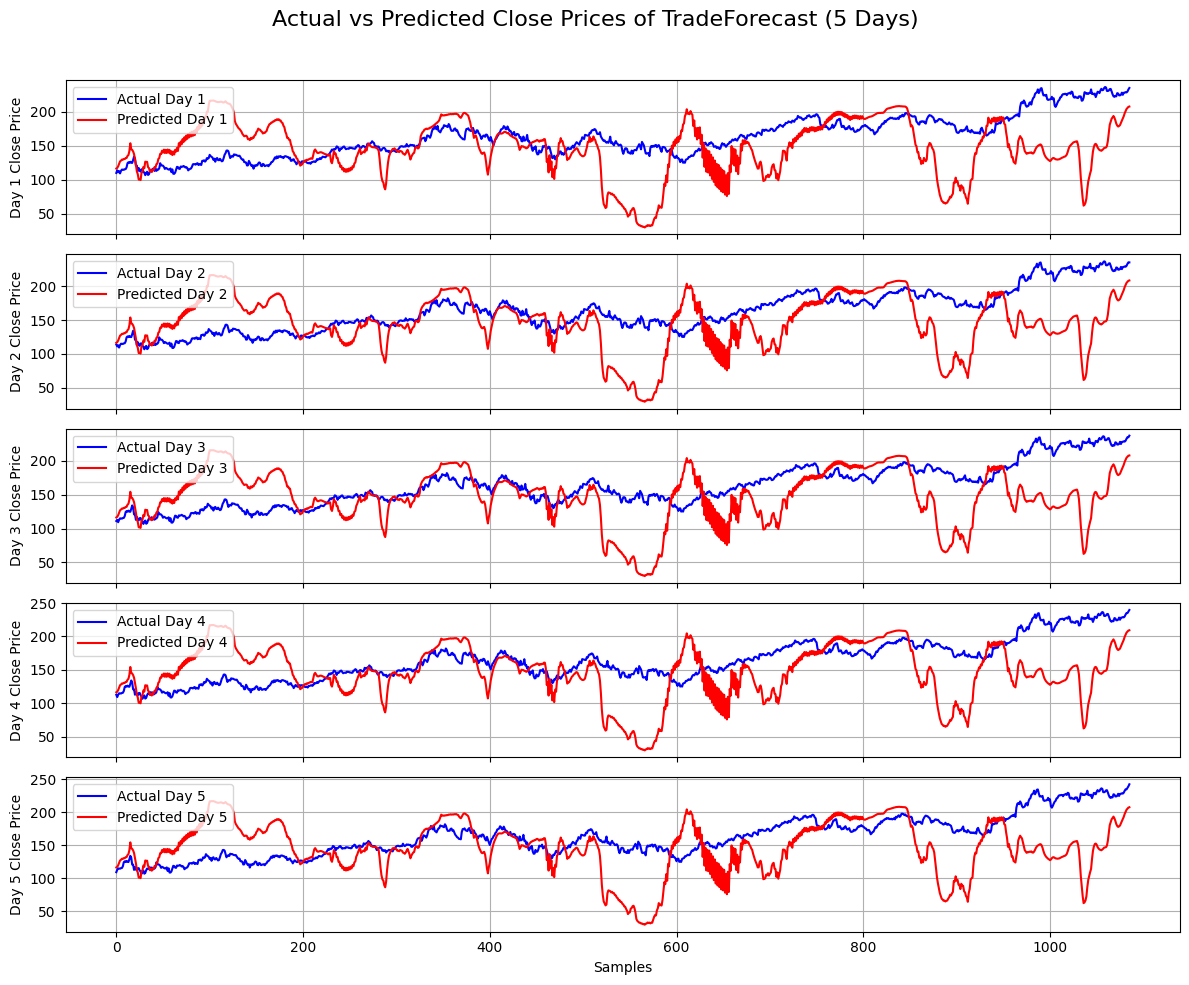

In [9]:
from tradeforecast.viz import plot_rnn_forecasts

plot_rnn_forecasts(y_arr, y_preds_arr)